In [24]:

#importing libraries
import numpy as np
import pandas as pd
#keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from keras.wrappers.scikit_learn import KerasClassifier




from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras import regularizers
from keras.layers import Dropout
from keras.utils import to_categorical

# for combining all the hyper-parameters
import itertools 
from time import time
from keras import initializers

In [25]:
# reading training and testing data from the csv file
train_df = pd.read_csv ('../data/monks-3-test.csv',header=None).to_numpy()
test_df = pd.read_csv ('../data/monks-3-train.csv',header=None).to_numpy()

In [26]:

#Preparing train_df for training
train_set = train_df[:, 1:7]
train_label = train_df[:, 0]
#Preparing test_df for testing
test_set = test_df[:, 1:7]
test_label = test_df[:, 0]

In [27]:
 test_set.shape ,test_label.shape , train_set.shape , train_label.shape

((122, 6), (122,), (432, 6), (432,))

In [28]:
# one hot encoding 
from keras.utils import to_categorical

def fix_zero(dataset):
  return dataset - 1

def to_one_hot_encoding(dataset):
    fixed_dataset = fix_zero(dataset)
    one_hot_dataset = []
    for column in fixed_dataset.T:
        one_hot_column = to_categorical(column)
        for column_index in range(one_hot_column.shape[1]):
            one_hot_dataset.append(one_hot_column[:,column_index])
    return np.asarray(one_hot_dataset).T

In [11]:
one_hot_train = to_one_hot_encoding(train_set)
one_hot_test  = to_one_hot_encoding(test_set)
one_hot_train.shape , train_label.shape ,one_hot_test.shape , test_label.shape

((432, 17), (432,), (122, 17), (122,))

In [96]:
def create_model(
                    lr=0.1, 
                    num_hidden_units=2,
#                     num_hidden_units2=3,
                    activation_hidden="tanh", 
#                     activation_hidden2="relu",
                    init_modes = "uniform",
                    activation_out="sigmoid",
                    momentum=0.7, 
                    decay= 0.1,
                    l2 = 0.01
                ):
    # create model
    model = Sequential()
#     initializer = initializers.GlorotNormal(seed=1) # has the parameter of seed to produce the same random sample.
    model.add(Dense(units=num_hidden_units, kernel_initializer= init_modes, input_dim=17, activation=activation_hidden))
#     model.add(Dense(units = num_hidden_units2,activation = activation_hidden2))
    model.add(Dense(1, activation=activation_out,bias_regularizer = keras.regularizers.l2(l2) ,kernel_regularizer=keras.regularizers.l2(l2))) 

    #optimizer
    sgd = SGD(lr=lr,decay = decay, momentum=momentum, nesterov=False)  # We can add decay to hyper parameter list to get optimum value. 

    # Compile model
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy'])
    return model

In [33]:
def plot_accuracy_two_params(history, title, ax):
    plt.subplot(ax)
    plt.plot(history.history['accuracy'], label='TR_set')
    plt.plot(history.history['val_accuracy'], label='VL_set')
    ax.set_title('Model Accuracy ' + title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')

def plot_loss_two_params(history, title, ax):
    plt.subplot(ax)
    plt.plot(history.history['loss'], label='TR_set')
    plt.plot(history.history['val_loss'], label='VL_set')
    ax.set_title('MEE ' + title)
    ax.set_ylabel('MEE')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')

def screening_phase(par_a, values_a, par_b, values_b, plot_function=plot_loss_two_params):
    num_values_a = len(values_a)
    num_values_b = len(values_b)
    f, axs = plt.subplots(nrows= num_values_a, ncols=num_values_b, figsize=(8*num_values_b, 5*num_values_a))
    for i in range(num_values_a):
        for j in range(num_values_b):
            params = {par_a : values_a[i], par_b : values_b[j]}
            model = KerasClassifier(build_fn=create_model, **params)
            history = model.fit(one_hot_train, train_label, validation_data=(one_hot_test, test_label), shuffle=True, epochs=90, batch_size=10, verbose=0)
            plot_title = '[' + par_a + ' = ' + str(values_a[i]) + '] [' + par_b + ' = ' + str(values_b[j]) + ']' 
            plot_function(history, plot_title, axs[i][j])
    plt.show()

screening phase to fined num_hidden_units and activation_out 

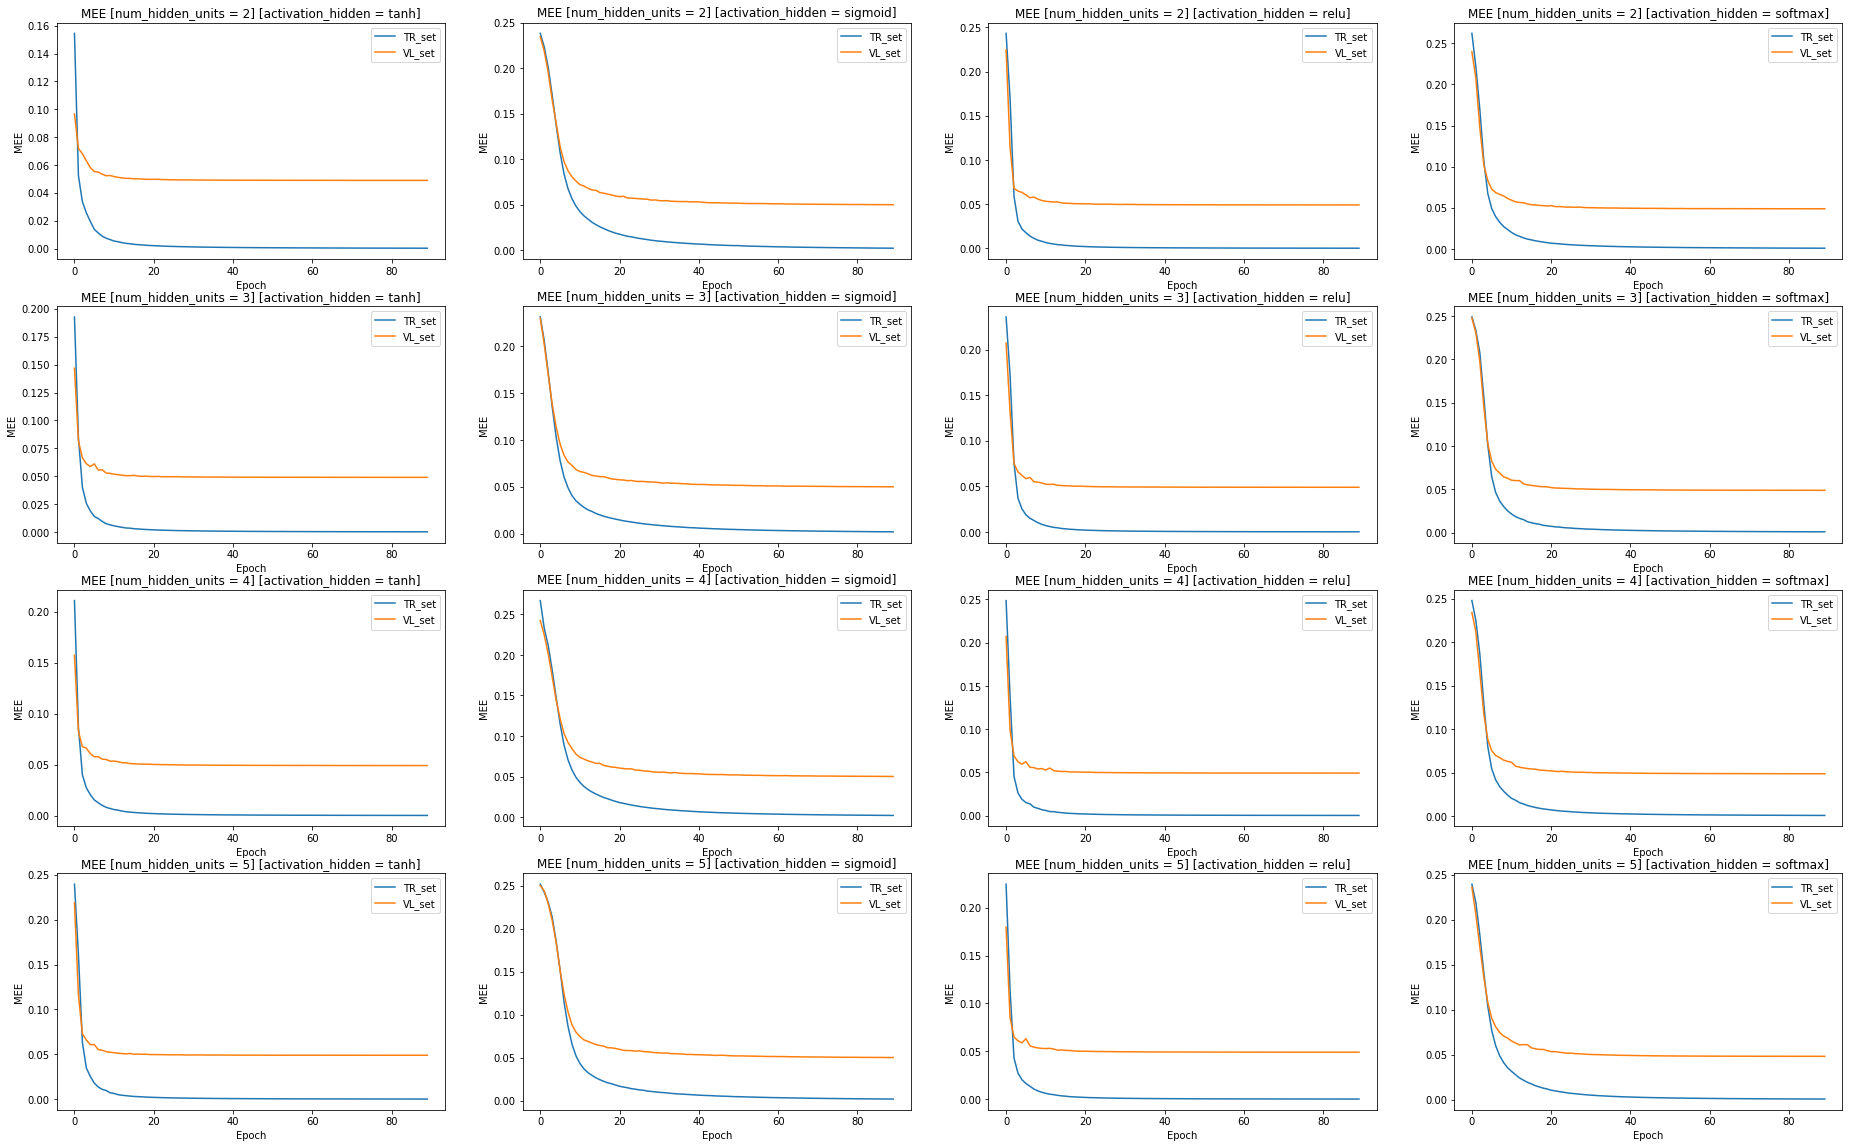

In [34]:
screening_phase( 'num_hidden_units', [2,3,4,5],'activation_hidden', ['tanh','sigmoid','relu','softmax'])

activation-out = sigmoid and num_hidden_units = 3

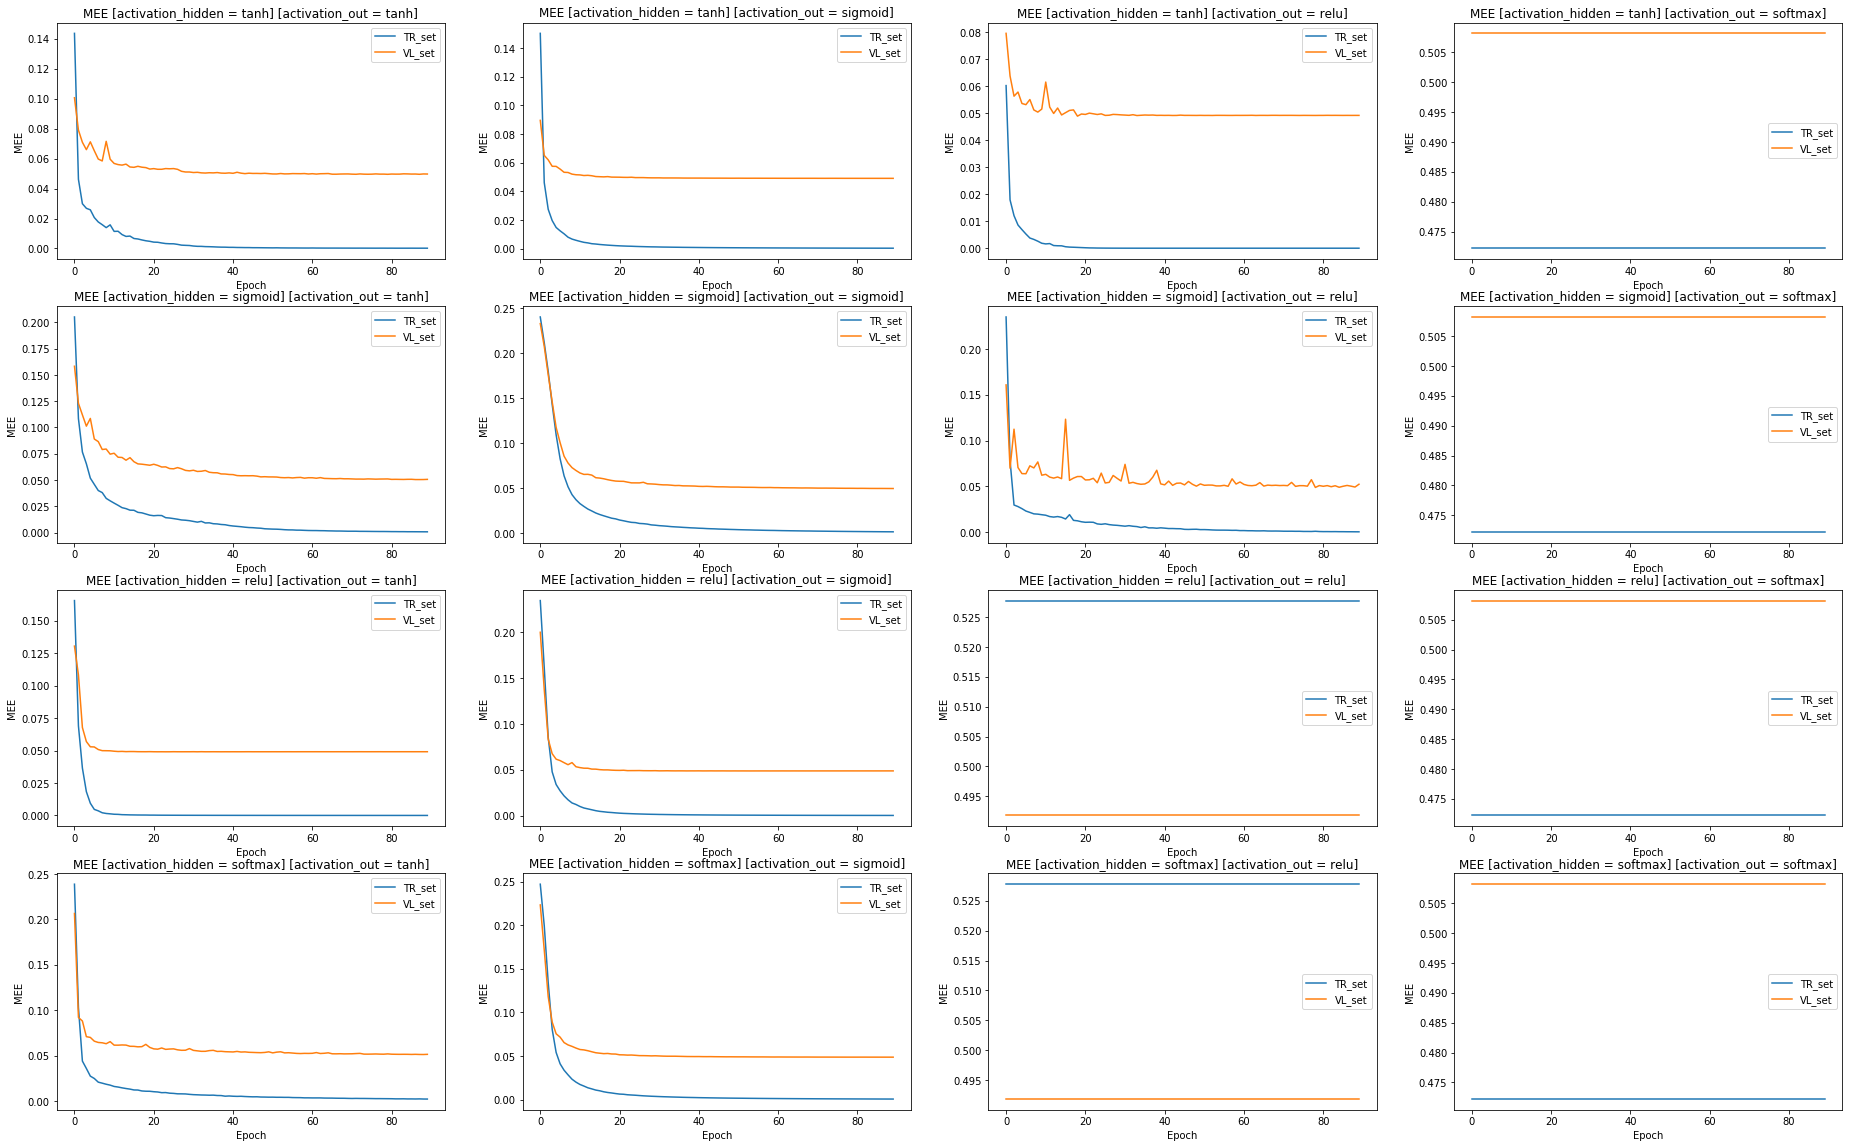

In [35]:
screening_phase('activation_hidden', ['tanh','sigmoid','relu','softmax'], 'activation_out', ['tanh','sigmoid','relu','softmax'])

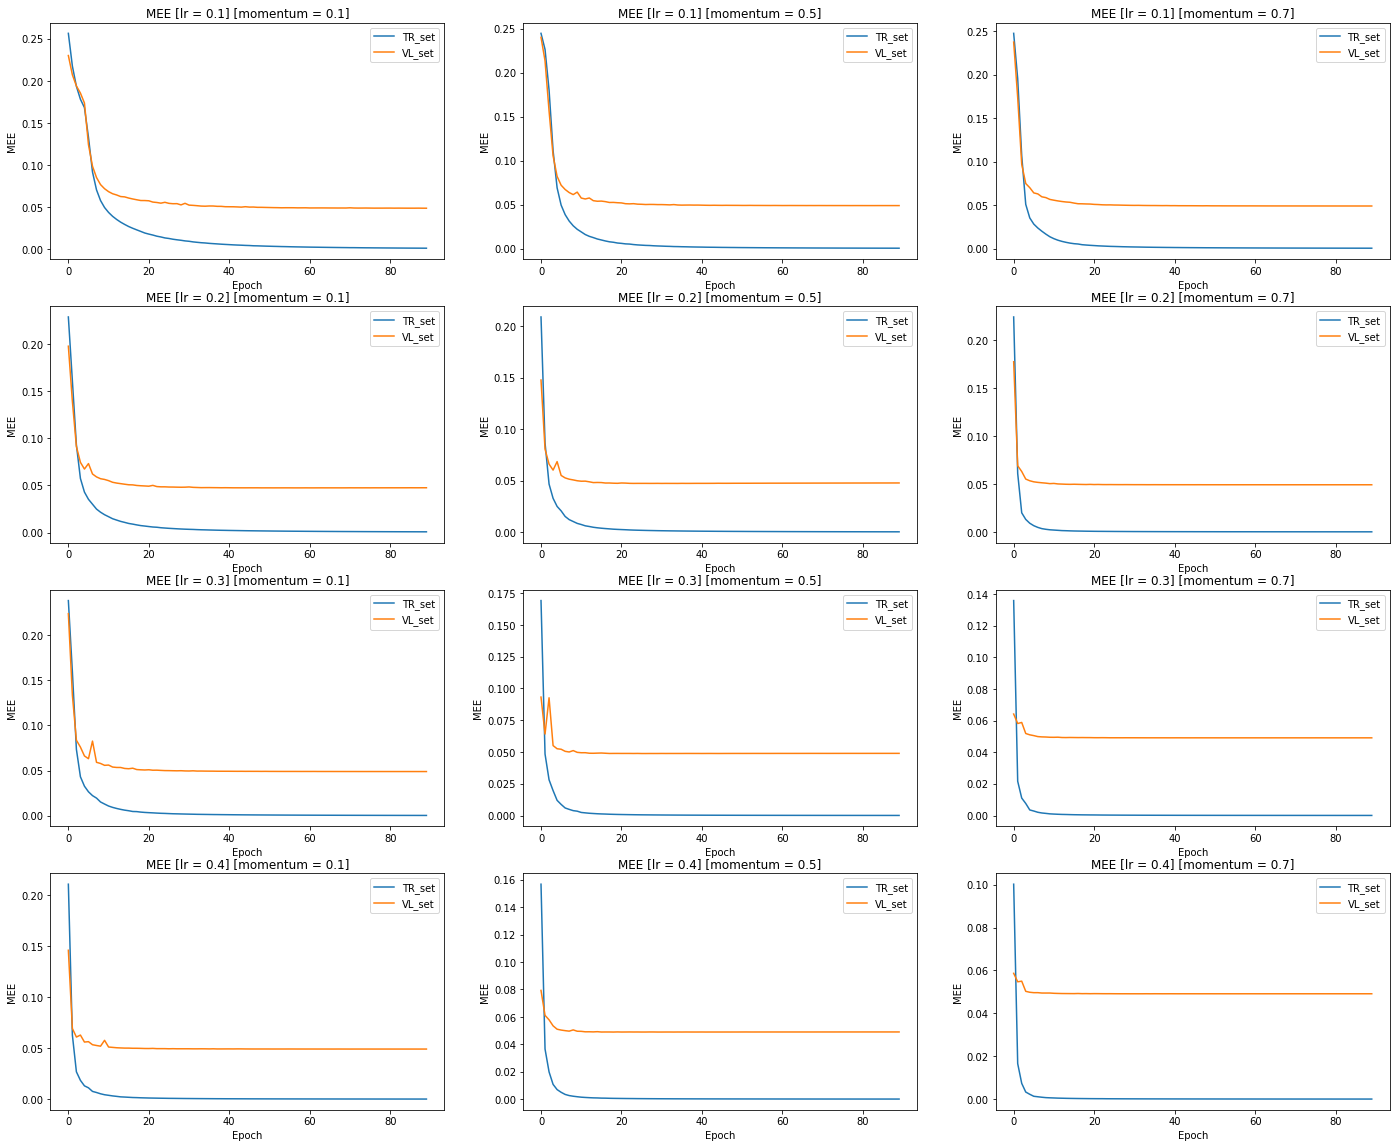

In [36]:
screening_phase('lr', [0.1,0.2,0.3,0.4], 'momentum', [0.1,0.5,0.7])

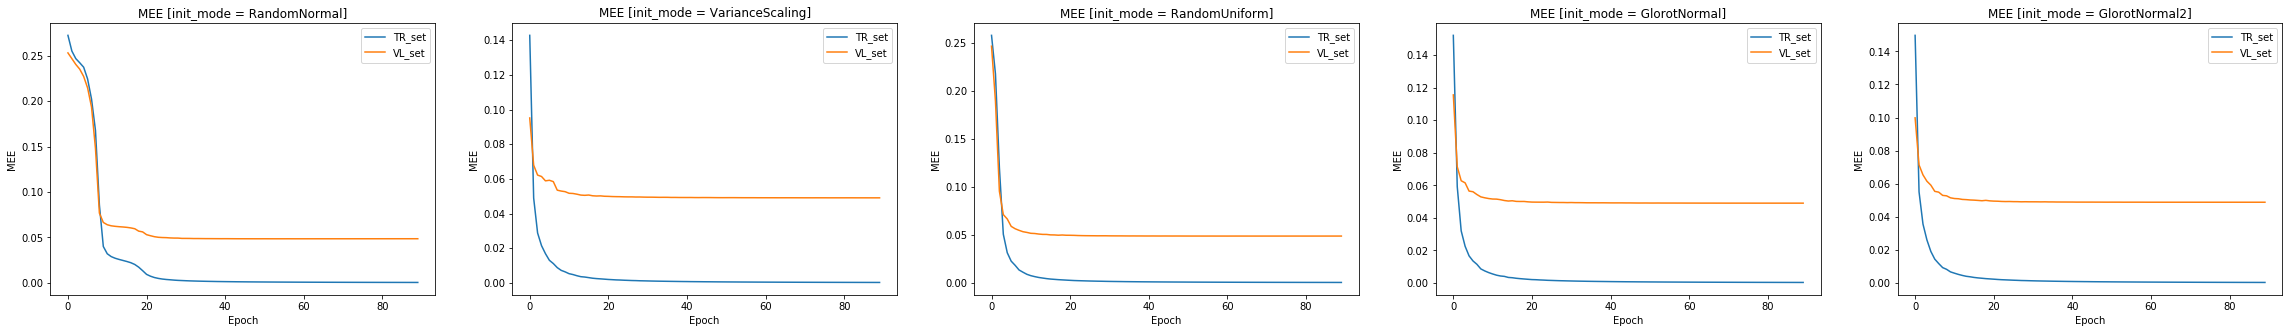

In [46]:
init_modes = [
    initializers.RandomNormal(mean=0., stddev=1., seed=52),
    initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal", seed=52),
    initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=52),
    initializers.GlorotNormal(seed=52),
    initializers.GlorotNormal(seed=1)
]
init_names = ['RandomNormal', 'VarianceScaling', 'RandomUniform', 'GlorotNormal','GlorotNormal2']


num_values_a = len(init_modes)

f, axs = plt.subplots(ncols=num_values_a, figsize=(8*num_values_a, 5))
for i in range(num_values_a):
    params = {'init_modes' : init_modes[i]}
    model = KerasClassifier(build_fn=create_model, **params)
    history = model.fit(one_hot_train, train_label, validation_data=(one_hot_test, test_label), shuffle=True, epochs=90, batch_size=10, verbose=0)
    plot_title = '[' + 'init_mode' + ' = ' + init_names[i] + ']'
    plot_loss_two_params(history, plot_title, axs[i])
plt.show()

In [42]:
# define the grid search parameters
param_grid_1 = {}
param_grid_1['lr'] = [0.1,0.2,0.3]
param_grid_1['momentum'] = [0.1, 0.7]
param_grid_1['num_hidden_units'] = [2,3,4]
# param_grid_1['num_hidden_units2'] = [2,3,4]
param_grid_1['activation_hidden'] = ['sigmoid','relu']
# param_grid_1['activation_hidden2'] = ['sigmoid', 'tanh']
param_grid_1['activation_out'] = ['tanh','sigmoid']
param_grid_1['epochs'] = [90,120,150] 
param_grid_1['batch_size'] = [10] 

In [54]:
# define the grid search parameters
param_grid_1 = {}
param_grid_1['lr'] = [0.1,0.2,0.3]
param_grid_1['momentum'] = [0.1, 0.7]
param_grid_1['num_hidden_units'] = [2,3,4]
# param_grid_1['num_hidden_units2'] = [2,3,4]
param_grid_1['activation_hidden'] = ['sigmoid','relu']
# param_grid_1['activation_hidden2'] = ['sigmoid', 'tanh']
param_grid_1['activation_out'] = ['tanh','sigmoid']
param_grid_1['epochs'] = [90,120,150] 
param_grid_1['batch_size'] = [10]
param_grid_1['decay'] = [0.1,0.01,0.001,0.0002,0.2]

In [97]:
# define the grid search parameters
param_grid_1 = {}
param_grid_1['lr'] = [0.1,0.2,0.3]
param_grid_1['momentum'] = [0.1, 0.7]
param_grid_1['num_hidden_units'] = [2,3,4]
# param_grid_1['num_hidden_units2'] = [2,3,4]
param_grid_1['activation_hidden'] = ['sigmoid','relu']
# param_grid_1['activation_hidden2'] = ['sigmoid', 'tanh']
param_grid_1['activation_out'] = ['tanh','sigmoid']
param_grid_1['l2'] = [0.1,0.001,1e-4,1e-5,1e-6]
param_grid_1['epochs'] = [90] 
param_grid_1['batch_size'] = [10]
param_grid_1['decay'] = [0.1,0.01]

In [98]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)

In [44]:
start=time()
model = KerasClassifier(build_fn=create_model) 
grid = GridSearchCV(estimator=model, param_grid=param_grid_1,n_jobs=6,cv=cv,verbose=1) 
grid_result = grid.fit(one_hot_train, train_label)
end=time() 
print("Total Running Time: %f",end-start)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Mean\tSTD\tParams")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 216 candidates, totalling 432 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 432 out of 432 | elapsed: 11.1min finished


Epoch 1/90
44/44 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.7824
Epoch 2/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9745
Epoch 3/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9792
Epoch 4/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0507 - accuracy: 0.9722
Epoch 5/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9722
Epoch 6/90
44/44 [==============================] - 0s 3ms/step - loss: 0.0393 - accuracy: 0.9745
Epoch 7/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9745
Epoch 8/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 0.9722
Epoch 9/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9722
Epoch 10/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.9745
Epoch 11/90
44/44 [

44/44 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 84/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 85/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 86/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 87/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 88/90
44/44 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 89/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 90/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 1.0000
Total Running Time: %f 672.3442184925079
Best: 1.000000 using {'activation_hidden': 'sigmoid', 'activation_out': 'tanh', 'batch_size': 10, 'epochs': 90, 'lr': 0.1, 'momentum': 0.7, 'num_hidden_units': 2}
Best: 1.000000 u

Total Running Time: %f 416.9085144996643
Best: 1.000000 using {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'epochs': 50, 'lr': 0.1, 'momentum': 0.7, 'num_hidden_units': 2}

est: 1.000000 using {'activation_hidden': 'sigmoid', 'activation_out': 'tanh', 'batch_size': 10, 'epochs': 90, 'lr': 0.1, 'momentum': 0.7, 'num_hidden_units': 2}

In [56]:
start=time()
model = KerasClassifier(build_fn=create_model) 
grid = GridSearchCV(estimator=model, param_grid=param_grid_1,n_jobs=6,cv=cv,verbose=1) 
grid_result = grid.fit(one_hot_train, train_label)
end=time() 
print("Total Running Time: %f",end-start)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Mean\tSTD\tParams")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 1080 candidates, totalling 2160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   54.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 23.1min
/home/anelay/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 32.6min
[Parallel(n_jobs=6)]: Done 2160 out of 2160 | elapsed: 39.6min finished


Epoch 1/90
44/44 [==============================] - 0s 1ms/step - loss: 0.2465 - accuracy: 0.5648
Epoch 2/90
44/44 [==============================] - 0s 1ms/step - loss: 0.1767 - accuracy: 0.8588
Epoch 3/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0906 - accuracy: 0.9676
Epoch 4/90
44/44 [==============================] - 0s 921us/step - loss: 0.0502 - accuracy: 0.9722
Epoch 5/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0395 - accuracy: 0.9722
Epoch 6/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.9722
Epoch 7/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0296 - accuracy: 0.9722
Epoch 8/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0264 - accuracy: 0.9722
Epoch 9/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0253 - accuracy: 0.9792
Epoch 10/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0229 - accuracy: 0.9815
Epoch 11/90
44/44

44/44 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 84/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 85/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 86/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 87/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 88/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 89/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 90/90
44/44 [==============================] - 0s 961us/step - loss: 0.0014 - accuracy: 1.0000
Total Running Time: %f 2379.667861700058
Best: 1.000000 using {'activation_hidden': 'sigmoid', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.1, 'epochs': 90, 'lr': 0.1, 'momentum': 0.7, 'num_hidden_units': 2}


1.000000 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 120, 'lr': 0.3, 'momentum': 0.7, 'num_hidden_units': 2}
1.000000 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 120, 'lr': 0.3, 'momentum': 0.7, 'num_hidden_units': 3}
1.000000 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 120, 'lr': 0.3, 'momentum': 0.7, 'num_hidden_units': 4}
1.000000 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 150, 'lr': 0.1, 'momentum': 0.1, 'num_hidden_units': 2}
0.990741 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 150, 'lr': 0.1, 'momentum': 0.1, 'num_hidden_units': 3}
0.997685 (0.002315) with: {'activation_hidden': 'sigmoid', 'activ

0.763889 (0.236111) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 2}
0.736111 (0.263889) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 3}
1.000000 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 4}
0.986111 (0.013889) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.3, 'momentum': 0.7, 'num_hidden_units': 2}
0.731481 (0.259259) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.3, 'momentum': 0.7, 'num_hidden_units': 3}
1.000000 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_s

1.000000 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.2, 'momentum': 0.7, 'num_hidden_units': 3}
1.000000 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.2, 'momentum': 0.7, 'num_hidden_units': 4}
1.000000 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 2}
1.000000 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 3}
1.000000 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.0002, 'epochs': 90, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 4}
0.763889 (0.236111) with: {'activation_hidden': 'relu', 'activation_out': '

In [99]:
#gridsearch for l2
start=time()
model = KerasClassifier(build_fn=create_model) 
grid = GridSearchCV(estimator=model, param_grid=param_grid_1,n_jobs=6,cv=cv,verbose=1) 
grid_result = grid.fit(one_hot_train, train_label)
end=time() 
print("Total Running Time: %f",end-start)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Mean\tSTD\tParams")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   32.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 1440 out of 1440 | elapsed: 19.9min finished


Epoch 1/90
44/44 [==============================] - 0s 1ms/step - loss: 0.1562 - accuracy: 0.8171
Epoch 2/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0264 - accuracy: 0.9722
Epoch 3/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0226 - accuracy: 0.9722
Epoch 4/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0203 - accuracy: 0.9722
Epoch 5/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0197 - accuracy: 0.9722
Epoch 6/90
44/44 [==============================] - 0s 984us/step - loss: 0.0186 - accuracy: 0.9769
Epoch 7/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0180 - accuracy: 0.9722
Epoch 8/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0174 - accuracy: 0.9861
Epoch 9/90
44/44 [==============================] - 0s 781us/step - loss: 0.0166 - accuracy: 0.9722
Epoch 10/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0163 - accuracy: 0.9722
Epoch 11/90
44/

44/44 [==============================] - 0s 1ms/step - loss: 0.0102 - accuracy: 1.0000
Epoch 84/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 85/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 86/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 87/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 88/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 89/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 90/90
44/44 [==============================] - 0s 1ms/step - loss: 0.0100 - accuracy: 1.0000
Total Running Time: %f 1197.8941745758057
Best: 1.000000 using {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.1, 'epochs': 90, 'l2': 0.001, 'lr': 0.2, 'momentum': 0.7, 'num_hidden_un

0.527778 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.2, 'momentum': 0.1, 'num_hidden_units': 2}
0.527778 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.2, 'momentum': 0.1, 'num_hidden_units': 3}
0.527778 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.2, 'momentum': 0.1, 'num_hidden_units': 4}
0.527778 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.2, 'momentum': 0.7, 'num_hidden_units': 2}
0.527778 (0.000000) with: {'activation_hidden': 'sigmoid', 'activation_out': 'sigmoid', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.2, 'momentum': 0.7, 'num_hidden_units': 3}
0.527778 (0.000

0.972222 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.2, 'momentum': 0.7, 'num_hidden_units': 4}
0.972222 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 2}
0.972222 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 3}
0.972222 (0.000000) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.3, 'momentum': 0.1, 'num_hidden_units': 4}
0.722222 (0.250000) with: {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.01, 'epochs': 90, 'l2': 0.1, 'lr': 0.3, 'momentum': 0.7, 'num_hidden_units': 2}
0.976852 (0.000000) with: {'activation_hidden

In [159]:
from tensorflow.keras import regularizers
from tensorflow import keras
model = Sequential()
initializer = initializers.RandomNormal(mean=0., stddev=1., seed=52) # seed to produce the same random sample.
model.add(Dense(units=4,kernel_initializer=initializer,input_dim=17,activation='relu',bias_regularizer = keras.regularizers.l2(0.001),kernel_regularizer=keras.regularizers.l2(0.001)))
# model.add(Dense(6, activation='sigmoid'))
model.add(Dense(1, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.001),bias_regularizer = keras.regularizers.l2(0.001)))
sgd = SGD(lr= 0.2,decay = 0.01,momentum=0.7 ,nesterov=False)
model.compile(optimizer=sgd,loss='mean_squared_error',metrics=['accuracy'])
history = model.fit(one_hot_train, train_label,validation_data=(one_hot_test, test_label), epochs= 90, batch_size=10,callbacks=[es], verbose=1)

Epoch 1/200
44/44 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.5278 - val_loss: 0.5672 - val_accuracy: 0.4918
Epoch 2/200
44/44 [==============================] - 0s 2ms/step - loss: 0.5243 - accuracy: 0.5278 - val_loss: 0.5389 - val_accuracy: 0.4918
Epoch 3/200
44/44 [==============================] - 0s 2ms/step - loss: 0.4947 - accuracy: 0.5278 - val_loss: 0.5032 - val_accuracy: 0.4918
Epoch 4/200
44/44 [==============================] - 0s 2ms/step - loss: 0.4441 - accuracy: 0.5046 - val_loss: 0.4029 - val_accuracy: 0.4918
Epoch 5/200
44/44 [==============================] - 0s 2ms/step - loss: 0.3359 - accuracy: 0.5625 - val_loss: 0.2907 - val_accuracy: 0.5820
Epoch 6/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2700 - accuracy: 0.5995 - val_loss: 0.2833 - val_accuracy: 0.6475
Epoch 7/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.6782 - val_loss: 0.2713 - val_accuracy: 0.6721
Epoch 8/200
4

Epoch 59/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0363 - accuracy: 1.0000 - val_loss: 0.0846 - val_accuracy: 0.9508
Epoch 60/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0361 - accuracy: 1.0000 - val_loss: 0.0845 - val_accuracy: 0.9508
Epoch 61/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 1.0000 - val_loss: 0.0843 - val_accuracy: 0.9508
Epoch 62/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.0843 - val_accuracy: 0.9508
Epoch 63/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 1.0000 - val_loss: 0.0841 - val_accuracy: 0.9508
Epoch 64/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.0840 - val_accuracy: 0.9508
Epoch 65/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.9508
Epoch 

44/44 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 0.9508
Epoch 117/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 0.9508
Epoch 118/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9508
Epoch 119/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9508
Epoch 120/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9508
Epoch 121/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.9508
Epoch 122/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.9508
Epoch 123/200

44/44 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.9508
Epoch 174/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.9508
Epoch 175/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.9508
Epoch 176/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.9508
Epoch 177/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.9508
Epoch 178/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.9508
Epoch 179/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.9508
Epoch 180/200

In [151]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
early_stopping = EarlyStopping()
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=1)

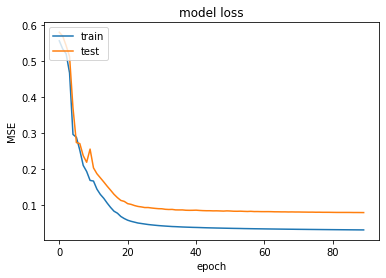

In [158]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('monk-3-learning curve')
plt.show()


gridsearch result after l2 Best: 1.000000 using {'activation_hidden': 'relu', 'activation_out': 'tanh', 'batch_size': 10, 'decay': 0.1, 'epochs': 90, 'l2': 0.001, 'lr': 0.2, 'momentum': 0.7, 'num_hidden_units': 4}